# Loss and time for batch/learning rate combinations

### No validation, 5 epochs, 2 runs

In [2]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import seaborn as sns

In [5]:
!ls logs/microseries/GTX_TITAN_X

loss       val_5epoch


In [15]:
logdir = "logs/microseries/GTX_TITAN_X/val_5epoch"

In [16]:
filename_pattern=re.compile(r"imagecaption_.*\.log")
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))
len(files)

96

In [17]:
output_pattern = re.compile(r"^(\d+),\s*([0-9\.]+),\s*([0-9\.]+)")
batch_learn_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_smp\d+_(\d+)")

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global output_pattern, batch_learn_pattern   
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    run = 0
    m = re.search(batch_learn_pattern, filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        run = int(m.group(3))
        if debug: print "BS,LR,run:",batch,learn,run
    
    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind = 0 # DataFrame row numebr (index)
        df = pd.DataFrame(data=None,columns=["batch","lr","run","epoch","time","loss"])
        for line in lines:
            s = line.strip(' \n')            
            m2 = output_pattern.match(s)
            if m2:
                if debug: print line,
                epoch = int(m2.group(1))
                time = float(m2.group(2))
                loss = float(m2.group(3))        
                if debug: print "BS,LR,run,epoch,time,loss:",batch,learn,run,epoch,time,loss
                df.loc[ind] = [batch,learn,run,epoch,time,loss]
                ind += 1                    
    return df

In [18]:
def readLogs(logdir, debug=False, maxfiles=10000000):
    global filename_pattern
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df = pd.DataFrame(data=None,columns=["batch","lr","run","epoch","time","loss"])

    filecounter=0
    for file in files:
        if debug: print file
        df1 = fileToDF(file,debug)
        if len(df1) > 0:
            df = pd.concat([df,df1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return df

In [19]:
print logdir
df_DL=readLogs(logdir)

logs/microseries/GTX_TITAN_X/val_5epoch


In [20]:
df_DL.describe()

,batch,lr,run,epoch,time,loss
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,14.250000,0.001767,0.500000,3.000000,100.372740,6.625957
std,8.809039,0.001388,0.500522,1.415689,236.223456,0.356402
min,2.000000,0.000100,0.000000,1.000000,11.994004,5.870124
25%,7.000000,0.000500,0.000000,2.000000,21.867088,6.380240
50%,14.000000,0.001500,0.500000,3.000000,39.360559,6.590118
75%,21.000000,0.003000,1.000000,4.000000,55.748396,6.802143
max,28.000000,0.004000,1.000000,5.000000,1521.224139,8.102448


In [22]:
df_5 = df_DL[df_DL["epoch"]==5]
df_1 = df_DL[df_DL["epoch"]==1]

In [25]:
df_mean = df_5.groupby(["batch","lr","epoch"]).mean().reset_index()
print df_mean.head()
df_mean = df_mean.drop(["epoch","run","time"],axis=1)
df_mean.head()

   batch      lr  epoch  run         time      loss
0    2.0  0.0001    5.0  0.5  1225.276355  7.010803
1    2.0  0.0005    5.0  0.5  1422.552907  6.893285
2    2.0  0.0010    5.0  0.5  1440.263267  7.065421
3    2.0  0.0020    5.0  0.5  1465.494914  6.801889
4    2.0  0.0030    5.0  0.5  1468.469971  6.803375


,batch,lr,loss
0,2.0,0.0001,7.010803
1,2.0,0.0005,6.893285
2,2.0,0.0010,7.065421
3,2.0,0.0020,6.801889
4,2.0,0.0030,6.803375


In [26]:
df_mean1 = df_1.groupby(["batch","lr","epoch"]).mean().reset_index().drop(["epoch","loss","run"],axis=1)

In [56]:
def plotHeatMap(df,title=None,cmap=None):
    plt.rcParams['figure.figsize'] = 7,6.37 
    plt.pcolormesh(df,cmap=cmap)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    ax = plt.gca()
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                plt.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.2, 'pad':0})
    plt.title(title,fontsize=18)
    plt.xlabel("learning rate",fontsize=12)
    plt.ylabel("minibatch size",fontsize=12)
    plt.colorbar()
    plt.show()

In [57]:
time_T = df_mean1.pivot_table(index="batch",columns="lr",values="time")
loss_T = df_mean.pivot_table(index="batch",columns="lr",values="loss")

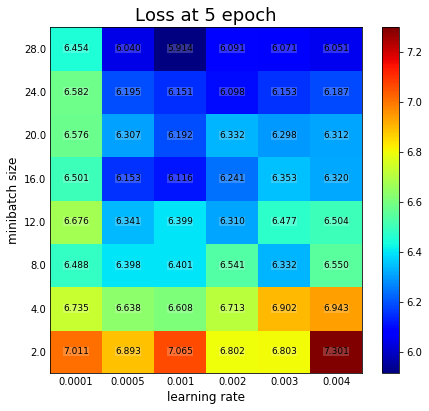

In [58]:
plotHeatMap(loss_T,"Loss at 5 epoch","jet")

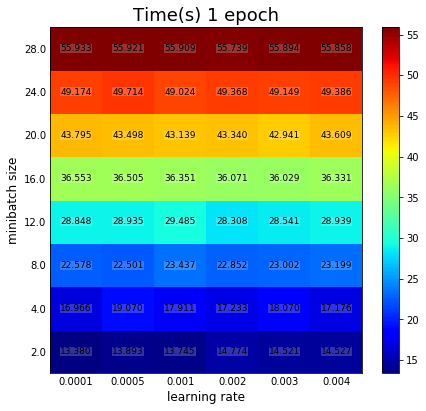

In [60]:
plotHeatMap(time_T,"Time(s) 1 epoch","jet")